In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


# Libraries

In [2]:
import warnings
import re
import time
from functools import partial
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from IPython.display import Image

import tensorflow as tf
from keras import layers
from keras import backend as K
from keras.layers import (BatchNormalization, Flatten, Dense, Dropout, Activation)
import keras_tuner
from tensorflow.keras.models import Sequential

from scipy.optimize import minimize
from scipy.stats import mstats
from scipy import stats

from sklearn.linear_model import (SGDOneClassSVM, LinearRegression)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.pipeline import Pipeline
from sklearn.impute import (KNNImputer, SimpleImputer)
from sklearn.ensemble import (HistGradientBoostingRegressor, ExtraTreesRegressor,
                              GradientBoostingRegressor, IsolationForest, BaggingRegressor,
                              StackingRegressor, RandomForestRegressor)
from sklearn.model_selection import (StratifiedKFold, KFold, StratifiedGroupKFold,
                                     RepeatedStratifiedKFold, RepeatedKFold, cross_validate,
                                     train_test_split)
from sklearn.preprocessing import (LabelEncoder, QuantileTransformer, StandardScaler,
                                   PowerTransformer, MaxAbsScaler, MinMaxScaler,
                                   RobustScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder)
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn import preprocessing
from sklearn.feature_selection import (VarianceThreshold, SequentialFeatureSelector, f_regression)
from sklearn.compose import ColumnTransformer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import optuna
from optuna.samplers import CmaEsSampler
from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def plot_numerical_features(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
    
    plt.tight_layout()
    plt.show()

def plot_numerical_boxplots(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.boxplot(x=df[feature], ax=axes[i])
        axes[i].set_title(f'Boxplot of {feature}')
    
    plt.tight_layout()
    plt.show()

def plot_qq_plot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        stats.probplot(df[feature], dist="norm", plot=axes[i])
        axes[i].set_title(f'QQ Plot of {feature}')
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, method='spearman'):
    num_df = df.select_dtypes(include=[np.number])
    
    corr = num_df.corr(method=method)
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title(f'Correlation Matrix ({method.capitalize()} Correlation)')
    plt.show()

def plot_pairplot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    sns.pairplot(df[num_features])
    plt.show()

def plot_categorical_features(df, ncols=2, top_n=None):
    cat_features = df.select_dtypes(include=[object]).columns
    nrows = (len(cat_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(cat_features):
        if top_n is not None:
            top_categories = df[feature].value_counts().nlargest(top_n).index
            sns.countplot(data=df[df[feature].isin(top_categories)], y=feature, ax=axes[i])  
        else:
            sns.countplot(data=df, y=feature, ax=axes[i])  
        
        axes[i].set_title(f'Count of {feature}')
        axes[i].tick_params(axis='y', rotation=0)  

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]
   
def optimize_memory_usage(df, print_size=True):
# Function optimizes memory usage in dataframe.

# Types for optimization.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Memory usage size before optimize (Mb).
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Memory usage size after optimize (Mb).
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Memory usage size: before {:5.4f} Mb - after {:5.4f} Mb ({:.1f}%).'.format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

# Description

**Forecasting Sticker Sales**

**Goal:** The objective of this challenge is to forecast sticker sales in different countries. "At Kaggle, we take stickers seriously!"

**Evaluation** Submissions are evaluated using the Mean Absolute Percentage Error (MAPE).

![Photo1-660x401.jpg](https://media.geeksforgeeks.org/wp-content/uploads/20210626210225/Photo1-660x401.jpg)

**Welcome to my github** - https://github.com/Alexsandrrus/projekts-Kaggle

# Load data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

train.shape, test.shape

((230130, 6), (98550, 5))

In [5]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [6]:
train = optimize_memory_usage(train)
test = optimize_memory_usage(test)

Memory usage size: before 10.5346 Mb - after 8.7789 Mb (16.7%).
Memory usage size: before 3.7595 Mb - after 3.3836 Mb (10.0%).


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int32  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float32
dtypes: float32(1), int32(1), object(4)
memory usage: 8.8+ MB


In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,230130.0,115064.500000,66432.953062,0.0,57532.25,115064.5,172596.75,230129.0
num_sold,221259.0,752.527405,690.165466,5.0,219.00,605.0,1114.00,5939.0


In [9]:
duplicates = train.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

Number of duplicates: 0


In [10]:
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

id - 0%
date - 0%
country - 0%
store - 0%
product - 0%
num_sold - 4%


In [11]:
test = test.drop(['id'], axis =1)
train = train.drop(['id'], axis =1)

In [12]:
train = train.dropna()
test = test.dropna()

train.shape, test.shape

((221259, 5), (98550, 4))

In [13]:
train['date'] = pd.to_datetime(train['date'], infer_datetime_format=True)
test['date'] = pd.to_datetime(test['date'], infer_datetime_format=True)

def date_time(df):
    df["trainweekday_sv"] = df["date"].dt.strftime("%a").astype("str")
    df["weekday_num"] = df["date"].dt.strftime("%w").astype("str")
    df["day_of_month"] = df["date"].dt.strftime("%d").astype("str")
    df["month_name_sv"] = df["date"].dt.strftime("%b").astype("str")
    df["month_num"] = df["date"].dt.strftime("%m").astype("int")
    df["year_fv"] = df["date"].dt.strftime("%Y").astype("int")
    df["day_number_year"] = df["date"].dt.strftime("%j").astype("int")
    df["week_number_year"] = df["date"].dt.strftime("%W").astype("str")
    df["country"] = df["country"].astype("str")
    df["store"] = df["store"].astype("str")
    df["product"] = df["product"].astype("str")
    df["year_sin"] = np.sin(2 * np.pi * df["year_fv"] / 7)
    df["year_cos"] = np.cos(2 * np.pi * df["year_fv"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month_num"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month_num"] / 12)
    return df

date_time(train)
date_time(test)

train = train.drop(['date'], axis=1)
test = test.drop(['date'], axis=1)

In [14]:
train.shape, test.shape

((221259, 16), (98550, 15))

# EDA

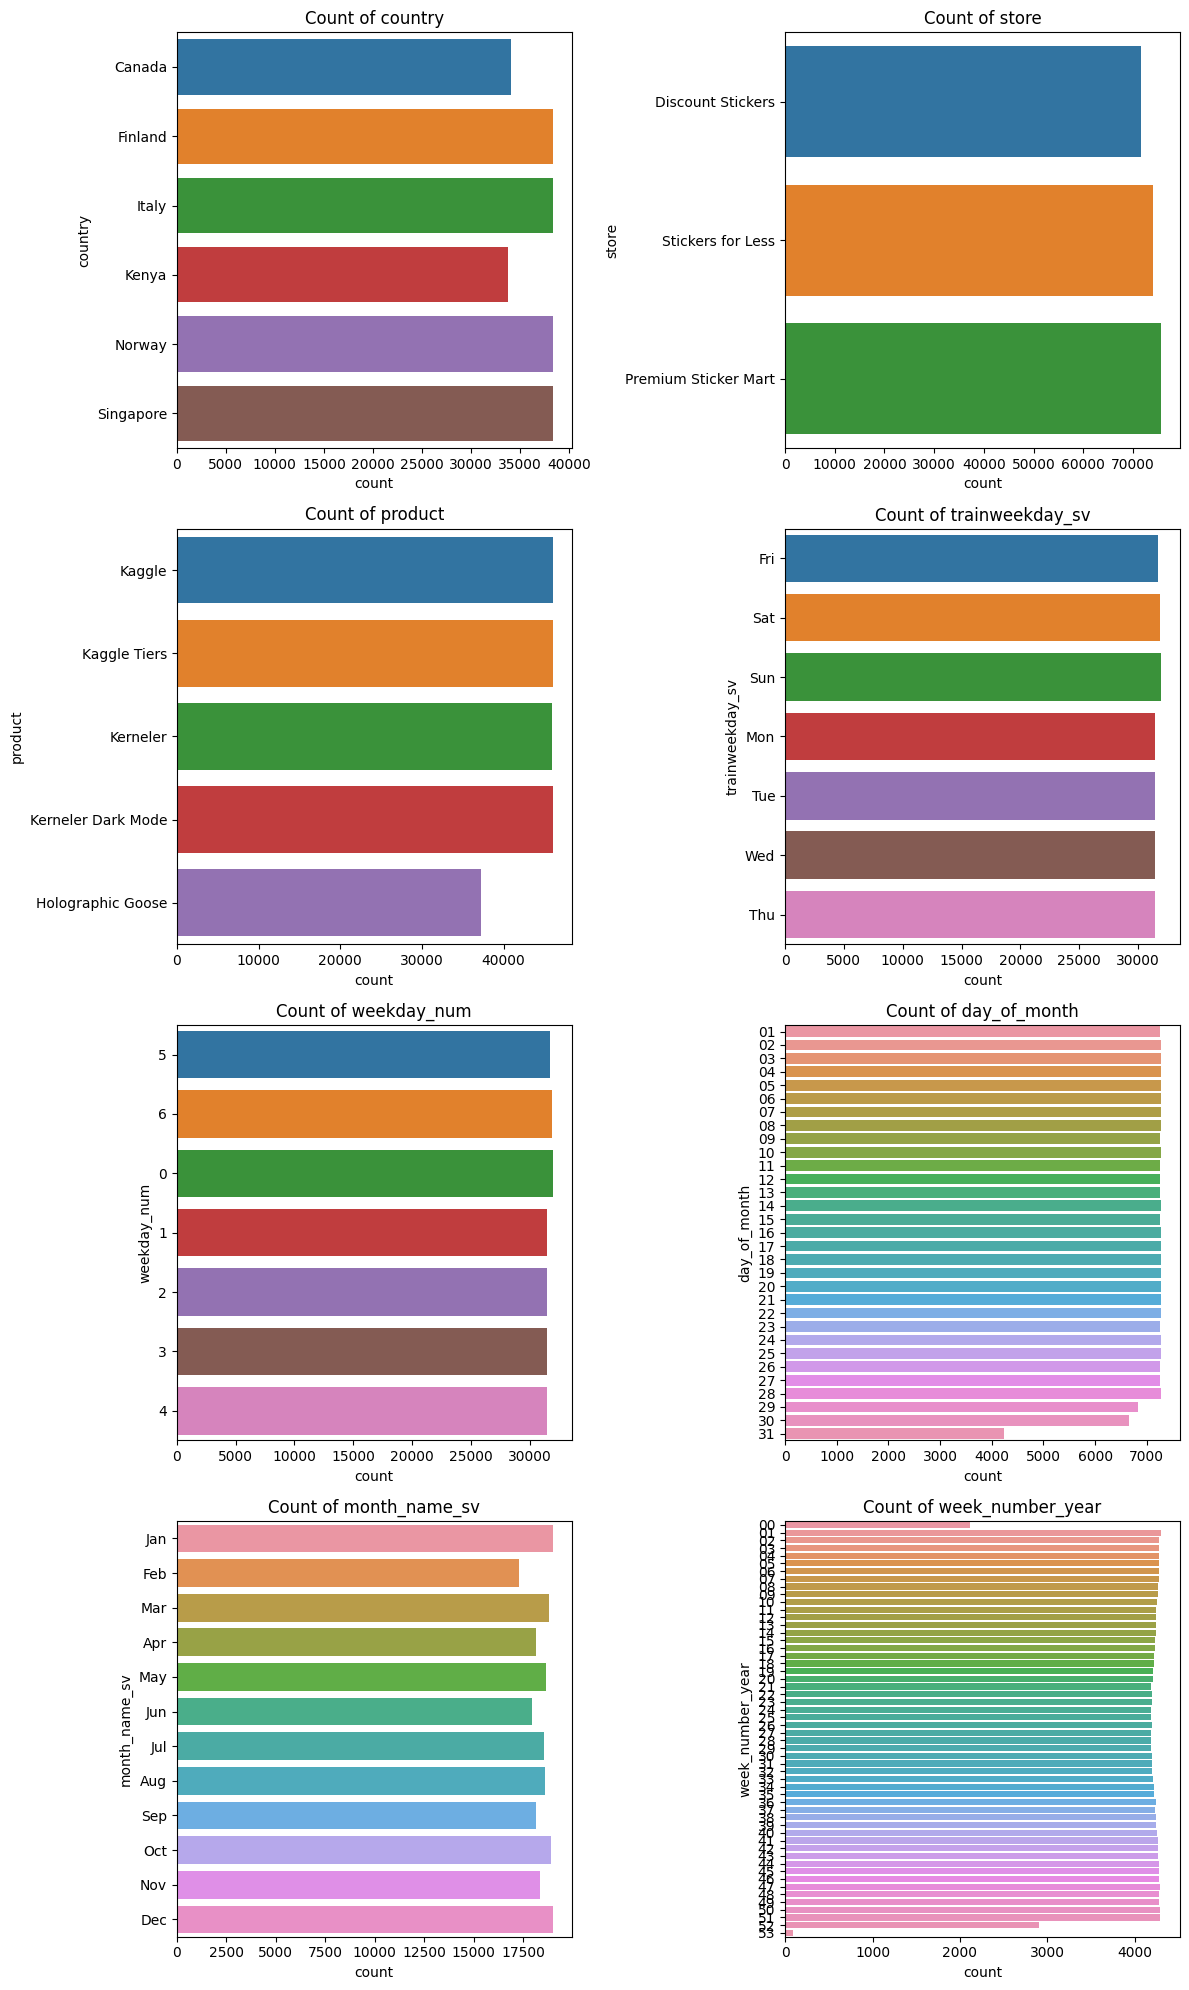

In [15]:
plot_categorical_features(train)

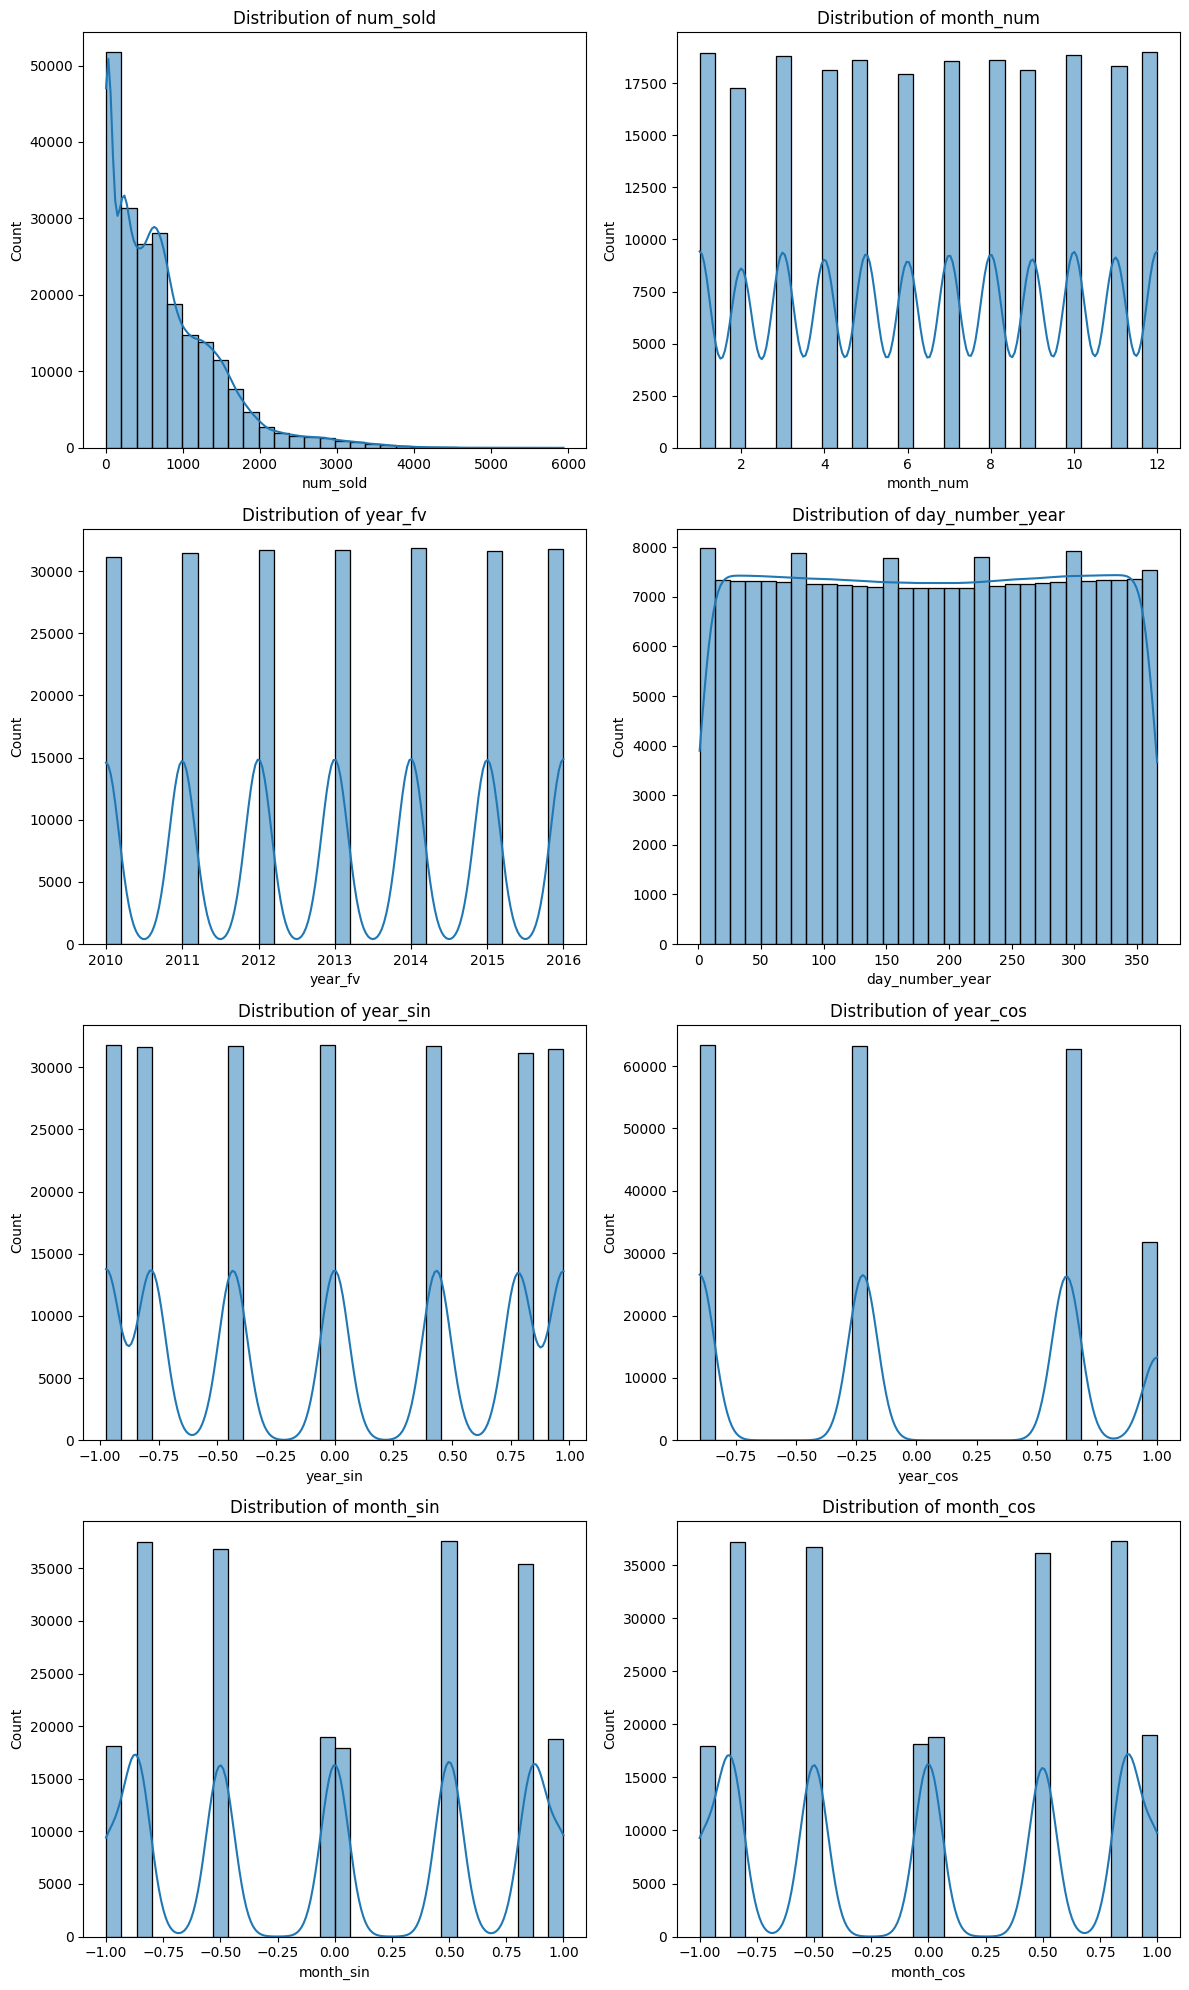

In [16]:
plot_numerical_features(train)

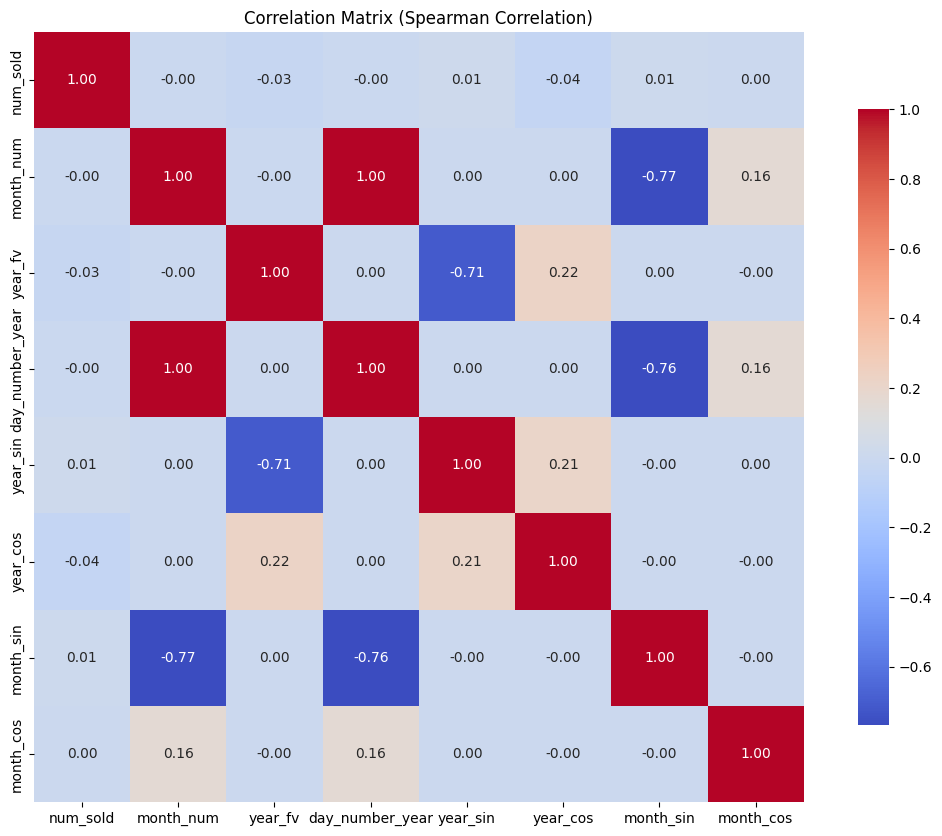

In [17]:
plot_correlation_matrix(train)

# Preparation

In [18]:
ord_cat = [['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore']]
ohe_columns = ['product', 'trainweekday_sv', 'month_name_sv','store','weekday_num','day_of_month', 'week_number_year']
ord_columns = ['country']
num_columns = ['month_num', 'year_fv', 'day_number_year', 'year_sin',
       'year_cos', 'month_sin', 'month_cos']

ohe_pipe = Pipeline(
    [
        ('imputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('imputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=ord_cat, handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

num_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),  
        ('scaler', StandardScaler())])

poly_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),  # Импутер для полиномиальных признаков
        ('poly', PolynomialFeatures(degree=2, include_bias=False))
    ]
)

power_transformer_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),
        ('power_transformer', PowerTransformer())
    ]
)
        
preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns),
        ('num_pol', poly_pipe, num_columns),
        ('num_transform', power_transformer_pipe, num_columns)], 
    remainder='passthrough'
) 

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('imputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['product', 'trainweekday_sv', 'month_name_sv',
                                  'store', 'weekday_num', 'day_of_month',
                                  'week_number_year']),
                                ('ord',
                                 Pipeline(steps=[('imput...
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['month_num', 'year_fv', 'day_number_year',
                                  'year_sin', 'year_cos', 'month_sin',
                                  'month_cos']),
                                ('num_transform',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('power_transformer',
                                                  PowerTransformer())]),
                                 ['month_num', 'year_fv', 'day_number_year',
                                  'year_sin', 'year_cos', 'month_sin',
                                  'month_cos'])])

# Optuna

In [19]:
X = train.drop(columns=['num_sold'])
y = train['num_sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(X_test)
test_transformed = preprocessor.transform(test)

X_train = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(X_test_transformed, columns=preprocessor.get_feature_names_out())
test = pd.DataFrame(test_transformed, columns=preprocessor.get_feature_names_out())

X_train = variance_threshold(X_train,0.04)
list_name = (X_train.columns)
X_test = X_test[list_name]
test = test[list_name]

X_train.shape, X_test.shape, y_train.shape, y_test.shape, test.shape

((177007, 79), (44252, 79), (177007,), (44252,), (98550, 79))

In [20]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 2, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10.0),  
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),  
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-2, 10.0),  
        'border_count': trial.suggest_int('border_count', 32, 255),  
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),  
        #'subsample': trial.suggest_uniform('subsample', 0.5, 1.0), 
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0), 
        'verbose': 0,
#          'task_type': 'GPU',
#           'devices': '0'  
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)
cat_params = study.best_params
print("Best hyperparameters: ", study.best_params)
print("Best MSE: ", study.best_value)

[I 2025-01-12 07:18:34,477] A new study created in memory with name: no-name-16cc3644-9fca-4bca-88ba-0e799984361c
[I 2025-01-12 07:19:07,899] Trial 0 finished with value: 428141.97071583266 and parameters: {'iterations': 238, 'depth': 10, 'learning_rate': 0.00024604392937188966, 'l2_leaf_reg': 0.008248753320468651, 'random_strength': 6.358827061912875e-08, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.5127010552832736, 'border_count': 131, 'min_data_in_leaf': 27}. Best is trial 0 with value: 428141.97071583266.
[I 2025-01-12 07:19:42,557] Trial 1 finished with value: 5940.314896045163 and parameters: {'iterations': 999, 'depth': 5, 'learning_rate': 0.07884857282354577, 'l2_leaf_reg': 0.056454383798173406, 'random_strength': 9.023305276365627e-05, 'leaf_estimation_iterations': 6, 'bagging_temperature': 2.011252163699224, 'border_count': 193, 'min_data_in_leaf': 8}. Best is trial 1 with value: 5940.314896045163.
[I 2025-01-12 07:21:20,190] Trial 2 finished with value: 7357.5

Best hyperparameters:  {'iterations': 737, 'depth': 11, 'learning_rate': 0.06913024595781692, 'l2_leaf_reg': 0.025831021025201576, 'random_strength': 0.05117703324356974, 'leaf_estimation_iterations': 1, 'bagging_temperature': 9.657921582728518, 'border_count': 181, 'min_data_in_leaf': 29}
Best MSE:  3154.601570647762


In [21]:
def objective_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),  
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),  
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),  
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),  
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.1, 10.0),  
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),  
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),  
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),  
        'colsample_bynode': trial.suggest_uniform('colsample_bynode', 0.5, 1.0),  
        'verbosity': 0,
#          'tree_method': 'gpu_hist'  
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              early_stopping_rounds=100,  
              verbose=0)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=150)

xgb_param = study_xgboost.best_params
print("Best hyperparameters for XGBoost:", study_xgboost.best_params)
print("Best RMSE score for XGBoost:", study_xgboost.best_value)


[I 2025-01-12 13:40:17,806] A new study created in memory with name: no-name-6a4913f9-efab-437e-a1eb-91e3adcf4aa0
[I 2025-01-12 13:40:33,578] Trial 0 finished with value: 690.9334716796875 and parameters: {'n_estimators': 276, 'max_depth': 14, 'learning_rate': 0.0003216891508317462, 'subsample': 0.5619309267285033, 'colsample_bytree': 0.6989729787942789, 'gamma': 0.2897628044615523, 'lambda': 0.0015239381094903188, 'alpha': 0.7719150354602343, 'min_child_weight': 8, 'scale_pos_weight': 5.996201800526804, 'grow_policy': 'lossguide', 'max_delta_step': 10, 'colsample_bylevel': 0.8052038658864096, 'colsample_bynode': 0.725834909623889}. Best is trial 0 with value: 690.9334716796875.
[I 2025-01-12 13:41:22,361] Trial 1 finished with value: 537.7767944335938 and parameters: {'n_estimators': 838, 'max_depth': 15, 'learning_rate': 0.04702343276238238, 'subsample': 0.6389863777505171, 'colsample_bytree': 0.9095577265750758, 'gamma': 3.0555300072621043, 'lambda': 0.013642014365416873, 'alpha': 1

Best hyperparameters for XGBoost: {'n_estimators': 743, 'max_depth': 13, 'learning_rate': 0.026725288826913444, 'subsample': 0.9825133820998717, 'colsample_bytree': 0.9420147781511907, 'gamma': 0.11006909213447745, 'lambda': 9.933736156275542, 'alpha': 0.6177493970251724, 'min_child_weight': 28, 'scale_pos_weight': 1.1630307633516594, 'grow_policy': 'depthwise', 'max_delta_step': 0, 'colsample_bylevel': 0.5444879052352137, 'colsample_bynode': 0.6676827531771303}
Best RMSE score for XGBoost: 57.139808654785156


In [22]:
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-3, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'objective': 'regression',
        'metric': 'rmse',
#          'device': 'gpu'  # Uncomment if GPU support is needed
    }

    model = LGBMRegressor(**params, early_stopping_rounds=100, verbose = -1)
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)])
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=150)

lgbm_param = study_lgbm.best_params
print("Best hyperparameters for LGBM:", study_lgbm.best_params)
print("Best RMSE score for LGBM:", study_lgbm.best_value)

[I 2025-01-12 16:07:01,051] A new study created in memory with name: no-name-83d6bca8-f0ec-4a18-96e4-c105cf7fa20c
[I 2025-01-12 16:07:40,721] Trial 0 finished with value: 174.5351028634965 and parameters: {'n_estimators': 790, 'max_depth': 14, 'learning_rate': 0.0030003279367162294, 'num_leaves': 73, 'subsample': 0.7906560786887792, 'colsample_bytree': 0.5945043174635575, 'lambda_l1': 1.6081752117952146, 'lambda_l2': 0.010088688798391199, 'min_child_weight': 46, 'min_split_gain': 0.0019495627212384012, 'bagging_fraction': 0.5735881288500241, 'bagging_freq': 6, 'feature_fraction': 0.782430488054142, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 174.5351028634965.
[I 2025-01-12 16:13:10,246] Trial 1 finished with value: 836.9274685140766 and parameters: {'n_estimators': 840, 'max_depth': 12, 'learning_rate': 0.00041714294602018977, 'num_leaves': 59, 'subsample': 0.5857785482414414, 'colsample_bytree': 0.5010503747320598, 'lambda_l1': 0.33114561603236375, 'lambda_l2': 0.0018965621

Best hyperparameters for LGBM: {'n_estimators': 454, 'max_depth': 11, 'learning_rate': 0.04538862780515034, 'num_leaves': 243, 'subsample': 0.9253085983826779, 'colsample_bytree': 0.7471707947449879, 'lambda_l1': 0.1150242331833583, 'lambda_l2': 5.029989249773881, 'min_child_weight': 2, 'min_split_gain': 0.0022211128320544678, 'bagging_fraction': 0.8060051226824133, 'bagging_freq': 1, 'feature_fraction': 0.9985075858089043, 'boosting_type': 'gbdt'}
Best RMSE score for LGBM: 55.57039932670409


# Model

In [23]:
model1 = CatBoostRegressor(**cat_params, verbose = 0)
model2 = xgb.XGBRegressor(**xgb_param)
model3 = LGBMRegressor(**lgbm_param, verbose = -1)

meta_model = LGBMRegressor(**lgbm_param, verbose = -1)

stacked_model = StackingRegressor(regressors=[model1, model2, model3], meta_regressor=meta_model)

stacked_model.fit(X_train, y_train)

y_pred = stacked_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 3567.14


# Predict and submit

In [24]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e1/sample_submission.csv')
sub['num_sold'] = stacked_model.predict(test)
sub

,id,num_sold
0,230130,129.642630
1,230131,914.170272
2,230132,835.724803
3,230133,406.562157
4,230134,456.458568
...,...,...
98545,328675,325.660500
98546,328676,2390.327670
98547,328677,1892.727653
98548,328678,951.691126


In [25]:
sub.to_csv('submission.csv', index=False)